# Dataset

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
#!/bin/bash
!kaggle datasets download utkarshps/skin-cancer-mnist10000-ham-augmented-dataset

Dataset URL: https://www.kaggle.com/datasets/utkarshps/skin-cancer-mnist10000-ham-augmented-dataset
License(s): CC-BY-NC-SA-4.0


In [ ]:
import zipfile
zip_ref = zipfile.ZipFile('skin-cancer-mnist10000-ham-augmented-dataset.zip', 'r')
zip_ref.extractall()
zip_ref.close()
print("Dataset Loaded")

Dataset Loaded


# Modules

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mimg
import matplotlib.image as mpimg

from scipy import stats
from sklearn.manifold import TSNE
from skimage import exposure
from skimage.filters import gaussian
from skimage.feature import canny
from skimage.restoration import denoise_bilateral
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras import layers,models
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam,SGD,Adamax
from tensorflow.keras.applications import VGG16,DenseNet121,ResNet50V2
from tensorflow.keras.preprocessing.image import load_img,img_to_array
from tensorflow.keras.regularizers import l2,l1
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.applications import EfficientNetB4,EfficientNetB7,EfficientNetB3
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint,LearningRateScheduler
from tensorflow.keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPool2D, Activation, GlobalAveragePooling2D, BatchNormalization, Input

import os
import math
import shutil
from pathlib import Path
from PIL import Image
import imutils
import cv2
import glob
import pickle
import random
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

# Initial Total from all directories

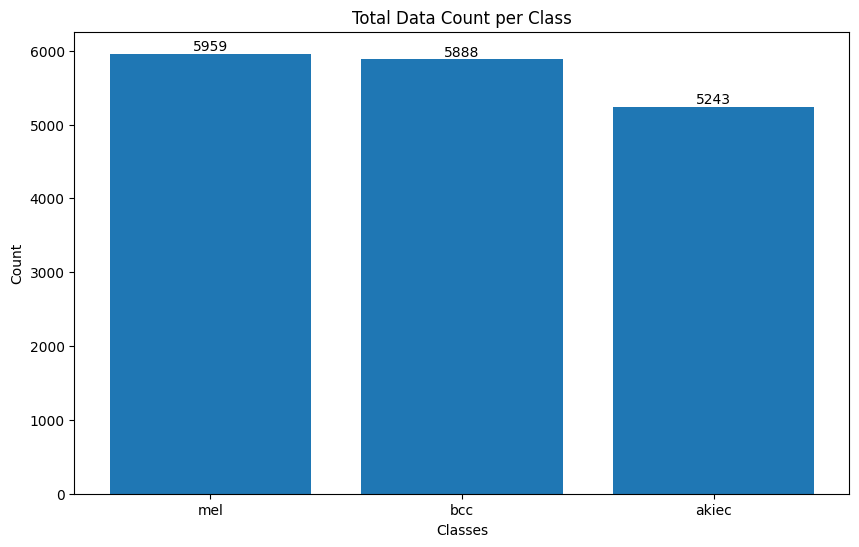

In [ ]:

import os
import matplotlib.pyplot as plt
import seaborn as sns

classes = ['mel', 'bcc', 'akiec']
base_dir = '/content/base_dir'
train_dir = os.path.join(base_dir, 'train_dir')
val_dir = os.path.join(base_dir, 'val_dir')

class_counts = {}

for class_name in classes:
    train_path = os.path.join(train_dir, class_name)
    val_path = os.path.join(val_dir, class_name)

    train_count = len([name for name in os.listdir(train_path) if os.path.isfile(os.path.join(train_path, name))])
    val_count = len([name for name in os.listdir(val_path) if os.path.isfile(os.path.join(val_path, name))])

    total_count = train_count + val_count
    class_counts[class_name] = total_count

plt.figure(figsize=(10, 6))
bars = plt.bar(class_counts.keys(), class_counts.values())
plt.title('Total Data Count per Class')
plt.xlabel('Classes')
plt.ylabel('Count')

for bar, count in zip(bars, class_counts.values()):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), count, ha='center', va='bottom')

plt.show()


# Undersampling Dataset

In [ ]:

import os
import shutil
import random


def undersample_dataset(source_dirs, target_dir, classes, sample_size):

    if not os.path.exists(target_dir):
        os.makedirs(target_dir)

    for class_name in classes:
        class_target_dir = os.path.join(target_dir, class_name)
        os.makedirs(class_target_dir, exist_ok=True)

        class_images = []
        for source_dir in source_dirs:
            class_path = os.path.join(source_dir, class_name)
            if os.path.exists(class_path):
                class_images.extend([os.path.join(class_path, img) for img in os.listdir(class_path) if os.path.isfile(os.path.join(class_path, img))])

        sampled_images = random.sample(class_images, min(sample_size, len(class_images)))

        for image_path in sampled_images:
            try:
                shutil.copy(image_path, class_target_dir)
            except FileNotFoundError:
                print(f"Warning: Image file not found: {image_path}")


source_directories = [train_dir, val_dir]
target_directory = 'Dataset'
selected_classes = ['mel', 'bcc', 'akiec']
desired_sample_size = 5200  

undersample_dataset(source_directories, target_directory, selected_classes, desired_sample_size)

print(f"Undersampled dataset created at: {target_directory}")


Undersampled dataset created at: Dataset


In [ ]:
print(len(os.listdir('/content/Dataset/mel')))
print(len(os.listdir('/content/Dataset/bcc')))
print(len(os.listdir('/content/Dataset/akiec')))

5200
5200
5200


# Params

In [ ]:
image_h = 224
image_w = 224
BATCH = 32
EPOCH = 30
classes = 3
channels = 3
image_h,image_w

(224, 224)

In [ ]:
dataset_folder = '/content/Dataset'


labels = ['mel', 'bcc', 'akiec']

list_path = []
list_labels = []
for label in labels:
    label_path = os.path.join(dataset_folder, label, "*")
    image_files = glob.glob(label_path)

    sign_label = [label] * len(image_files)


    list_path.extend(image_files)
    list_labels.extend(sign_label)

dataframe = pd.DataFrame({
    "image_path": list_path,
    "label": list_labels
})

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    dataframe["image_path"],
    dataframe["label"],
    test_size=0.15,
    random_state=2024,
    shuffle=True,
    stratify = dataframe["label"]
)

train_df = pd.DataFrame({
    "image_path": X_train,
    "label": y_train
})

X_train, X_val, y_train, y_val = train_test_split(
    train_df["image_path"], train_df["label"],
    test_size=0.15,
    random_state=2024,
    shuffle=True,
    stratify=train_df["label"]
)
train_df = pd.DataFrame({
    "image_path": X_train,
    "label": y_train
})
val_df = pd.DataFrame({
    "image_path": X_val,
    "label": y_val
})
test_df = pd.DataFrame({
    "image_path": X_test,
    "label": y_test
})


# 5200

In [ ]:
datagen = ImageDataGenerator(
    rescale=1/255.,
    # rotation_range=45,
    # width_shift_range=0.2,
    # height_shift_range=0.2,
    # shear_range=0.2,
    # zoom_range=0.2,
    # horizontal_flip=True,
    # vertical_flip=True ,
    # brightness_range=[0.8, 1.2]  # Adjust brightness
    # fill_mode='nearest'
)
# Training Dataset
train_gen = datagen.flow_from_dataframe(
    train_df,
    directory="./",
    x_col="image_path",
    y_col="label",
    class_mode="categorical",
    target_size=(image_h,image_w),
    batch_size=BATCH
)

# Testing Dataset
test_gen = datagen.flow_from_dataframe(
    test_df,
    directory="./",
    x_col="image_path",
    y_col="label",
    class_mode="categorical",
    target_size=(image_h,image_w),
    batch_size=BATCH,
    shuffle=False
)
# Validation Dataset
val_gen = datagen.flow_from_dataframe(
    val_df,
    directory="./",
    x_col="image_path",
    y_col="label",
    class_mode="categorical",
    target_size=(image_h,image_w),
    batch_size=BATCH
)




Found 11271 validated image filenames belonging to 3 classes.
Found 2340 validated image filenames belonging to 3 classes.
Found 1989 validated image filenames belonging to 3 classes.


# 5000

In [ ]:
datagen = ImageDataGenerator(
    rescale=1/255.,
    # rotation_range=45,
    # width_shift_range=0.2,
    # height_shift_range=0.2,
    # shear_range=0.2,
    # zoom_range=0.2,
    # horizontal_flip=True,
    # vertical_flip=True ,
    # brightness_range=[0.8, 1.2]  # Adjust brightness
    # fill_mode='nearest'
)
# Training Dataset
train_gen = datagen.flow_from_dataframe(
    train_df,
    directory="./",
    x_col="image_path",
    y_col="label",
    class_mode="categorical",
    target_size=(image_h,image_w),
    batch_size=BATCH
)

# Testing Dataset
test_gen = datagen.flow_from_dataframe(
    test_df,
    directory="./",
    x_col="image_path",
    y_col="label",
    class_mode="categorical",
    target_size=(image_h,image_w),
    batch_size=BATCH,
    shuffle=False
)
# Validation Dataset
val_gen = datagen.flow_from_dataframe(
    val_df,
    directory="./",
    x_col="image_path",
    y_col="label",
    class_mode="categorical",
    target_size=(image_h,image_w),
    batch_size=BATCH
)




Found 10837 validated image filenames belonging to 3 classes.
Found 2250 validated image filenames belonging to 3 classes.
Found 1913 validated image filenames belonging to 3 classes.


In [ ]:
early_stopping = EarlyStopping(monitor='val_loss',
                              patience=5,
                              restore_best_weights=True,
                              verbose=False)

def scheduler(epoch, lr):
    decay = -0.1
    if epoch < 5:
        return float(lr)
    else:
        return float(lr * math.exp((epoch + 1) * decay))

lrscheduler = LearningRateScheduler(scheduler)

checkpoint = ModelCheckpoint(
    "model_checkpoint.keras",
    monitor="val_loss",
    verbose=False,
    save_best_only=True,
    mode="auto",
)

callbacks = [checkpoint, lrscheduler, early_stopping]

# 5200 each class


In [ ]:
# EfficientNet
base_model = EfficientNetB3(
    weights='imagenet',
    include_top=False,
    input_shape=(image_h, image_w, 3),
    pooling='max'
)

eff_model = Sequential([
    base_model,
    BatchNormalization(),
    Dense(256, activation= 'relu'),
    Dropout(0.2),
    Dense(3, activation= 'softmax',kernel_regularizer= l2(1e-3),name="softmax")
])

eff_model.summary()

43941136/43941136 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ efficientnetb3 (Functional)          │ (None, 1536)                │      10,783,535 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 1536)                │           6,144 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │         393,472 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ softmax (Dense)                      │ (None, 3)                   │             771 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 11,183,922 (42.66 MB)

 Trainable params: 11,093,547 (42.32 MB)

 Non-trainable params: 90,375 (353.03 KB)

In [ ]:
# Compile the model
eff_model.compile(Adamax(learning_rate= 0.0001), loss= 'categorical_crossentropy', metrics= ['accuracy'])


eff_model.fit(
    train_gen,
    # steps_per_epoch=train_gen.samples // BATCH,
    validation_data=val_gen,
    # validation_steps=val_gen.samples // BATCH,
    epochs=EPOCH,
    callbacks=callbacks,
    verbose=True
)

Epoch 1/30
353/353 ━━━━━━━━━━━━━━━━━━━━ 308s 471ms/step - accuracy: 0.5570 - loss: 1.0585 - val_accuracy: 0.3308 - val_loss: 1.5084 - learning_rate: 1.0000e-04
Epoch 2/30
353/353 ━━━━━━━━━━━━━━━━━━━━ 95s 267ms/step - accuracy: 0.7936 - loss: 0.5131 - val_accuracy: 0.5963 - val_loss: 0.9946 - learning_rate: 1.0000e-04
Epoch 3/30
353/353 ━━━━━━━━━━━━━━━━━━━━ 97s 273ms/step - accuracy: 0.8546 - loss: 0.3674 - val_accuracy: 0.8421 - val_loss: 0.4121 - learning_rate: 1.0000e-04
Epoch 4/30
353/353 ━━━━━━━━━━━━━━━━━━━━ 94s 266ms/step - accuracy: 0.8978 - loss: 0.2712 - val_accuracy: 0.7798 - val_loss: 0.6812 - learning_rate: 1.0000e-04
Epoch 5/30
353/353 ━━━━━━━━━━━━━━━━━━━━ 95s 269ms/step - accuracy: 0.9304 - loss: 0.1864 - val_accuracy: 0.9015 - val_loss: 0.2727 - learning_rate: 1.0000e-04
Epoch 6/30
353/353 ━━━━━━━━━━━━━━━━━━━━ 93s 263ms/step - accuracy: 0.9472 - loss: 0.1460 - val_accuracy: 0.9015 - val_loss: 0.2869 - learning_rate: 5.4881e-05
Epoch 7/30
353/353 ━━━━━━━━━━━━━━━━━━━━ 96s 2

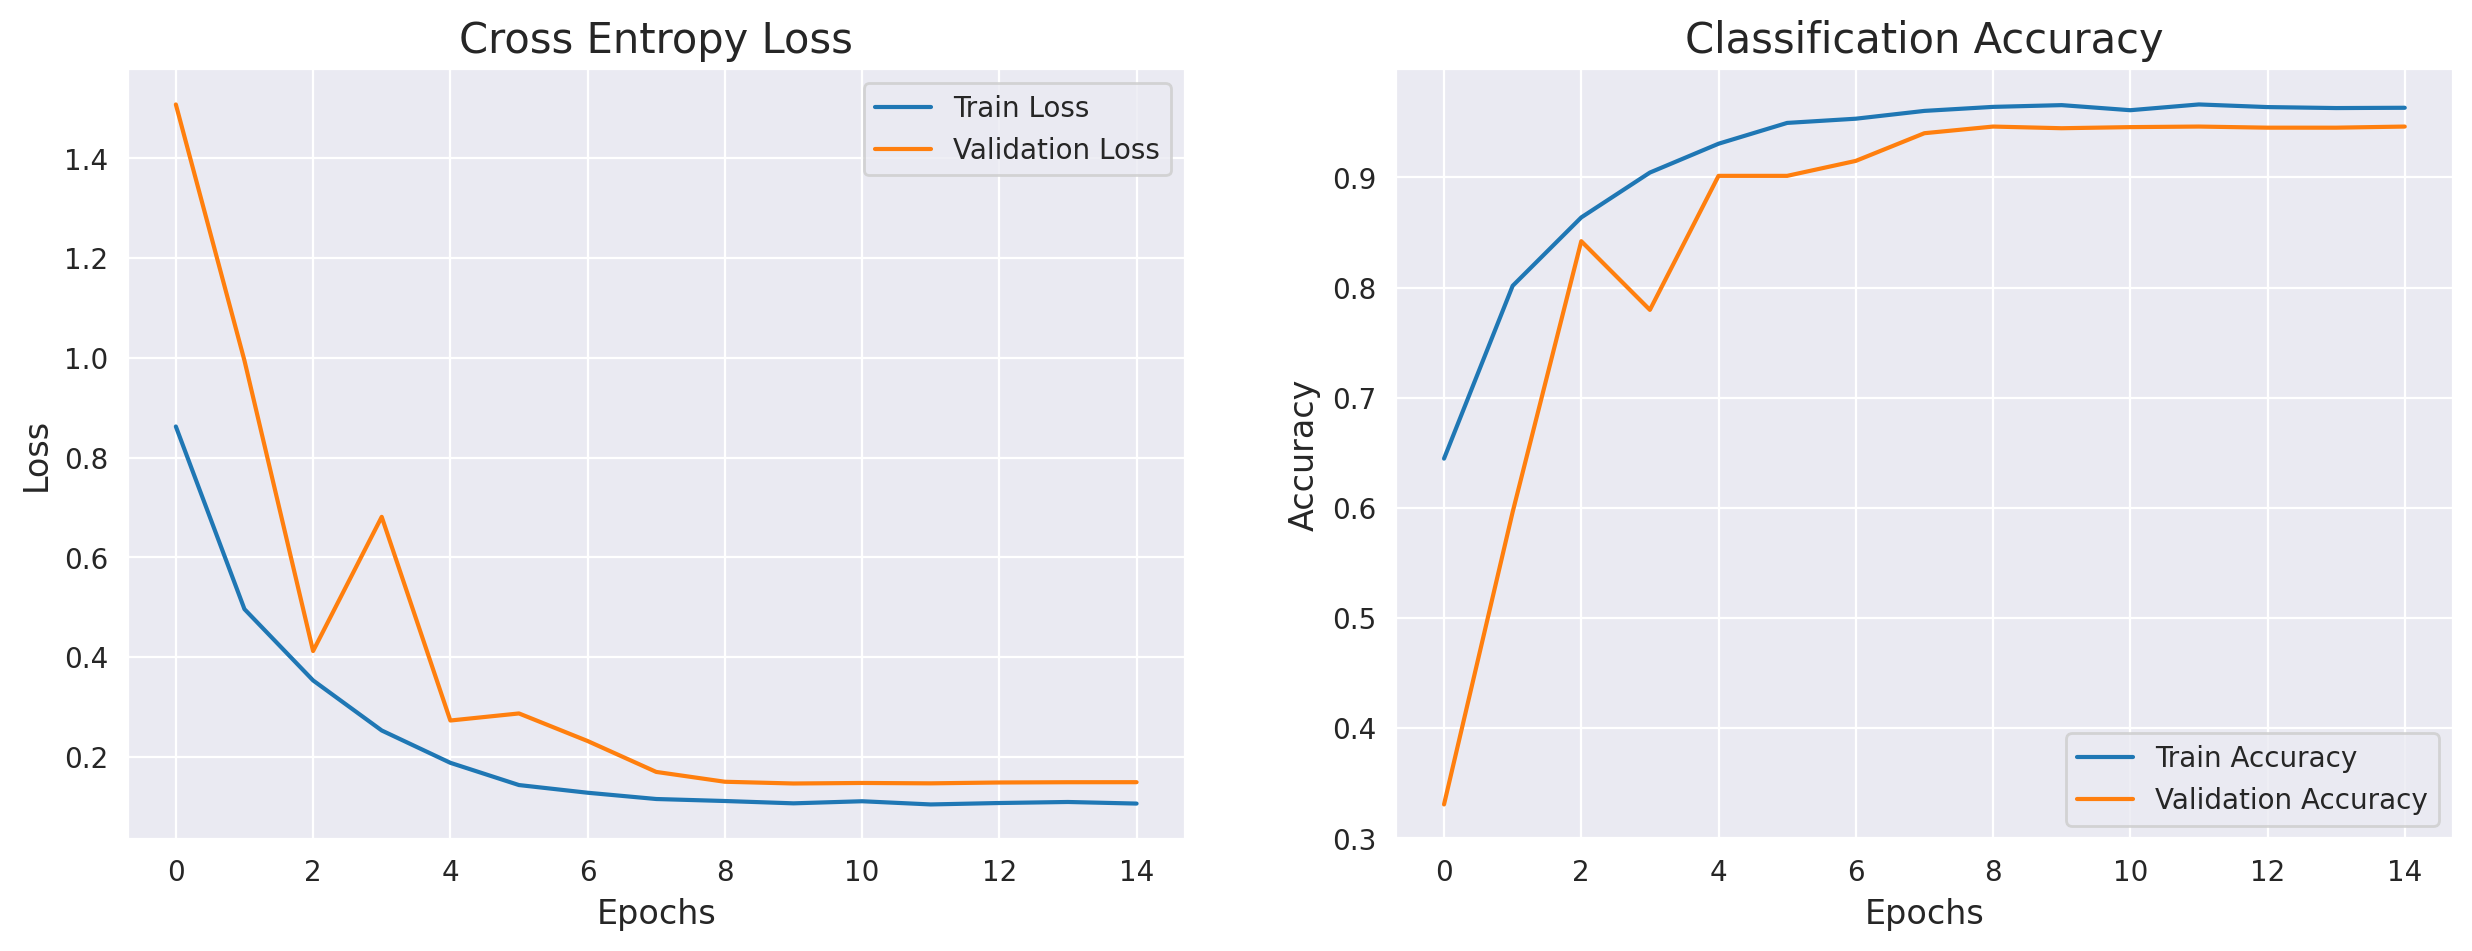

In [ ]:
# graphs
metrics = pd.DataFrame(model.history.history)

plt.figure(figsize=(15,5),dpi=200)
sns.set_style('darkgrid')

  # Loss and Val_loss
plt.subplot(121)
plt.title('Cross Entropy Loss',fontsize=15)
plt.xlabel('Epochs',fontsize=12)
plt.ylabel('Loss',fontsize=12)
plt.plot(metrics['loss'], label='Train Loss')
plt.plot(metrics['val_loss'], label='Validation Loss')
plt.legend()

  # Accuracy and Val_accuracy
plt.subplot(122)
plt.title('Classification Accuracy',fontsize=15)
plt.xlabel('Epochs',fontsize=12)
plt.ylabel('Accuracy',fontsize=12)
plt.plot(metrics['accuracy'], label='Train Accuracy')
plt.plot(metrics['val_accuracy'], label='Validation Accuracy')
plt.legend()

plt.show()


Model Testing 

The accuracy of the model for testing data is: 94.44444179534912
The Loss of the model for testing data is: 0.16806676983833313
Correct predicted classes: 2210
Incorrect predicted classes: 130

Classification Report 

              precision    recall  f1-score   support

       akiec       0.92      0.96      0.94       780
         bcc       0.95      0.95      0.95       780
         mel       0.96      0.92      0.94       780

    accuracy                           0.94      2340
   macro avg       0.94      0.94      0.94      2340
weighted avg       0.94      0.94      0.94      2340

Confusion Matrix 



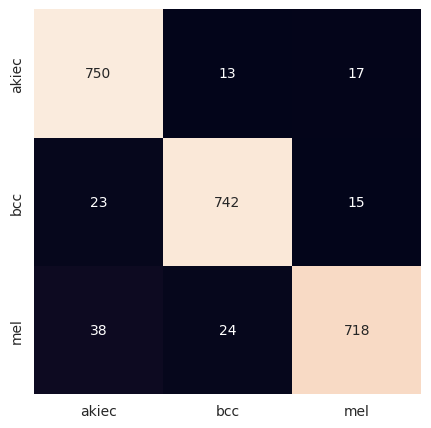

In [ ]:
all_evaluation(eff_model)

In [ ]:
model.save("efficient_net_b3_malignant_3_class_15march.keras")

In [ ]:
from google.colab import files
files.download("efficient_net_b3_malignant_3_class_15march.keras")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# 5000 each class

In [ ]:
# EfficientNet
base_model = EfficientNetB3(
    weights='imagenet',
    include_top=False,
    input_shape=(image_h, image_w, 3),
    pooling='max'
)

eff_model = Sequential([
    base_model,
    BatchNormalization(),
    Dense(256, activation= 'relu'),
    Dropout(0.3),
    Dense(3, activation= 'softmax',kernel_regularizer= l2(1e-3),name="softmax")
])

eff_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ efficientnetb3 (Functional)          │ (None, 1536)                │      10,783,535 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 1536)                │           6,144 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 256)                 │         393,472 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ softmax (Dense)                      │ (None, 3)                   │             771 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 11,183,922 (42.66 MB)

 Trainable params: 11,093,547 (42.32 MB)

 Non-trainable params: 90,375 (353.03 KB)

In [ ]:
# Compile the model
eff_model.compile(Adamax(learning_rate= 0.0001), loss= 'categorical_crossentropy', metrics= ['accuracy'])


eff_model.fit(
    train_gen,
    # steps_per_epoch=train_gen.samples // BATCH,
    validation_data=val_gen,
    # validation_steps=val_gen.samples // BATCH,
    epochs=EPOCH,
    callbacks=callbacks,
    verbose=True
)

Epoch 1/30
339/339 ━━━━━━━━━━━━━━━━━━━━ 273s 472ms/step - accuracy: 0.5456 - loss: 1.0872 - val_accuracy: 0.3152 - val_loss: 1.5518 - learning_rate: 1.0000e-04
Epoch 2/30
339/339 ━━━━━━━━━━━━━━━━━━━━ 95s 281ms/step - accuracy: 0.7562 - loss: 0.5998 - val_accuracy: 0.6968 - val_loss: 0.7680 - learning_rate: 1.0000e-04
Epoch 3/30
339/339 ━━━━━━━━━━━━━━━━━━━━ 142s 282ms/step - accuracy: 0.8422 - loss: 0.4135 - val_accuracy: 0.7778 - val_loss: 0.5569 - learning_rate: 1.0000e-04
Epoch 4/30
339/339 ━━━━━━━━━━━━━━━━━━━━ 95s 280ms/step - accuracy: 0.8855 - loss: 0.2934 - val_accuracy: 0.7047 - val_loss: 0.7891 - learning_rate: 1.0000e-04
Epoch 5/30
339/339 ━━━━━━━━━━━━━━━━━━━━ 96s 282ms/step - accuracy: 0.9112 - loss: 0.2333 - val_accuracy: 0.8458 - val_loss: 0.4168 - learning_rate: 1.0000e-04
Epoch 6/30
339/339 ━━━━━━━━━━━━━━━━━━━━ 95s 280ms/step - accuracy: 0.9390 - loss: 0.1622 - val_accuracy: 0.8181 - val_loss: 0.4820 - learning_rate: 5.4881e-05
Epoch 7/30
339/339 ━━━━━━━━━━━━━━━━━━━━ 143s

Graphs 



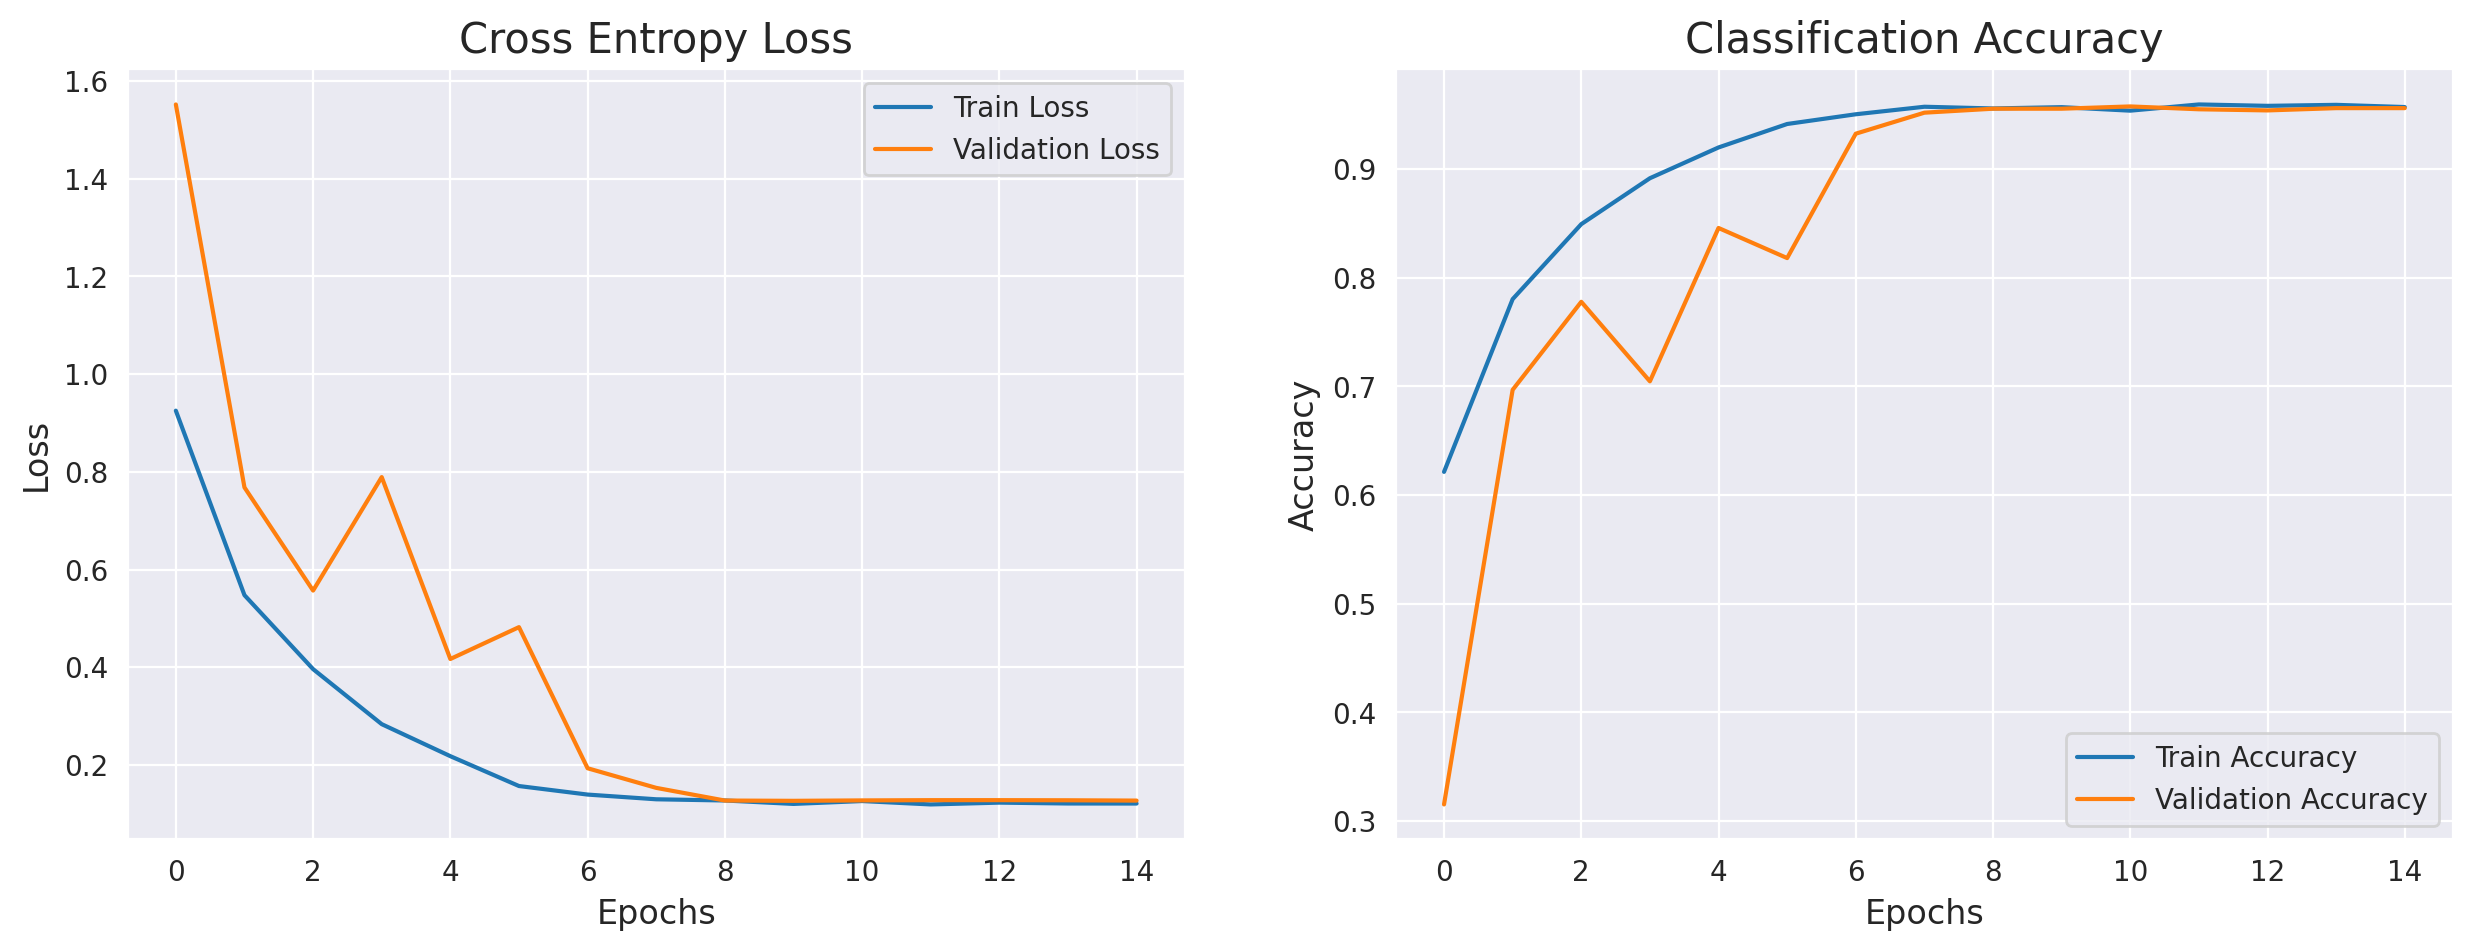


Model Testing 

The accuracy of the model for testing data is: 95.06666660308838
The Loss of the model for testing data is: 0.14528460800647736
Correct predicted classes: 2139
Incorrect predicted classes: 111

Classification Report 

              precision    recall  f1-score   support

       akiec       0.94      0.96      0.95       750
         bcc       0.95      0.96      0.96       750
         mel       0.95      0.94      0.95       750

    accuracy                           0.95      2250
   macro avg       0.95      0.95      0.95      2250
weighted avg       0.95      0.95      0.95      2250

Confusion Matrix 



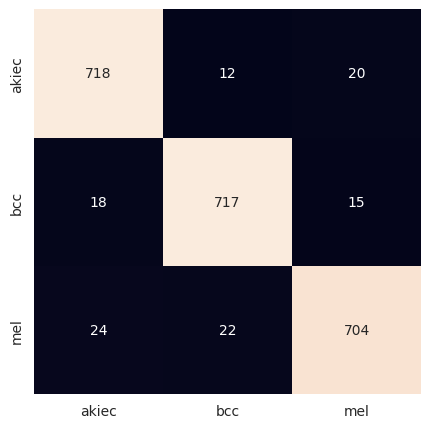

In [ ]:
all_evaluation(eff_model)

In [ ]:
def all_evaluation(model):

  # graphs
  print("Graphs \n")
  metrics = pd.DataFrame(model.history.history)

  plt.figure(figsize=(15,5),dpi=200)
  sns.set_style('darkgrid')

    # Loss and Val_loss
  plt.subplot(121)
  plt.title('Cross Entropy Loss',fontsize=15)
  plt.xlabel('Epochs',fontsize=12)
  plt.ylabel('Loss',fontsize=12)
  plt.plot(metrics['loss'], label='Train Loss')
  plt.plot(metrics['val_loss'], label='Validation Loss')
  plt.legend()

    # Accuracy and Val_accuracy
  plt.subplot(122)
  plt.title('Classification Accuracy',fontsize=15)
  plt.xlabel('Epochs',fontsize=12)
  plt.ylabel('Accuracy',fontsize=12)
  plt.plot(metrics['accuracy'], label='Train Accuracy')
  plt.plot(metrics['val_accuracy'], label='Validation Accuracy')
  plt.legend()

  plt.show()

  print('\nModel Testing \n')

  loss, acc = model.evaluate(test_gen, verbose=False)

  print('The accuracy of the model for testing data is:', acc*100)
  print('The Loss of the model for testing data is:', loss)

  predicted_class = model.predict(test_gen, verbose=False)
  predicted_class = np.argmax(predicted_class, axis=1)
  actual_class = test_gen.labels

  correct = np.nonzero(predicted_class == actual_class)[0]
  incorrect = np.nonzero(predicted_class != actual_class)[0]

  print("Correct predicted classes:", correct.shape[0])
  print("Incorrect predicted classes:", incorrect.shape[0])

  # classification report
  print('\nClassification Report \n')


  g_dict = test_gen.class_indices
  categories = list(g_dict.keys())

  print(classification_report(actual_class, predicted_class,
                            target_names=categories))

  # confusion matrix
  print('Confusion Matrix \n')

  con_matrix = tf.math.confusion_matrix(
        labels=actual_class,
        predictions=predicted_class,
        num_classes=classes)

  plt.figure(figsize=(5,5))
  sns.heatmap(con_matrix, annot=True, fmt='g', cbar=False, xticklabels=categories, yticklabels=categories)
  plt.show()

